## Convolution Filter 

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import handy_roms_spec


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [2]:
gc.collect()
# gc.garbage.clear()

0

In [4]:
def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x


In [5]:
def ultimate_filter2d(lon,lat,var,filter_scale,dim_x,dim_y):
    #filter scale in km
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        var_sm = var.copy()
        var_sm += np.nan;

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])



        varA  = gs ** 2 * var # multiplication with area
        varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
        var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
        # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
        var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
        var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
        var_sm[:] = var_sm_tmp2
    return var_sm


In [6]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [6]:
dxx=0.5
dyy=dxx

In [7]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [8]:
import datetime

# t_ind=pd.DatetimeIndex(varf.time_counter.compute())
t_ind=varf.time_counter.groupby("time_counter.dayofyear").mean()
mon_ind=t_ind.dt.month
mes=np.array([12,1,2,3,4,5,6,7])
mes_str=['Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

## Loading temperature

In [9]:
%%time
chunks_new={'dayofyear':40}


tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[0,100:-100,100:-200].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[0,100:-100,100:-200].compute();

CPU times: user 5.05 s, sys: 9.98 s, total: 15 s
Wall time: 4.59 s


In [30]:
# import seawater as sw
# grid=sw.dist(lon=varf.nav_lon_rho,lat=varf.nav_lat_rho)[0][100:-99,100:-200]
# gs=xr.DataArray(grid,dims=('y_rho','x_rho'))


In [29]:
# tfm = np.zeros((len(scales),tf.shape[0],tf.shape[1])) + np.nan
# ttm = np.zeros((len(scales),tt.shape[0],tt.shape[1])) + np.nan
# counter=0

In [28]:
# %%time
# scale_tmp=scales[0]
#     # create convolution kernel for each grid-cell

    
# radius = int( (scale_tmp / gs.min().compute() / 2 ).round()) 
# # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing


# window_size = 2 * radius + 1


# gsr = gs.rolling(x_rho=window_size, center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

# gsr_lat = gsr.cumsum("lat_window")
# gsr_lat -= gsr_lat.isel(lat_window=radius)
# gsr_lon = gsr.cumsum("lon_window")
# gsr_lon -= gsr_lon.isel(lon_window=radius)
# circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < scale_tmp / 2)
# Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])


In [31]:
# %%time
# # convolute tf
# tfA  = gs ** 2 * tf # multiplication with area
# tfAr = tfA.rolling(x_rho=window_size, center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
# tfm_tmp = ((tfAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
# # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
# tfm_tmp2 = np.zeros((tfm_tmp.shape)) + np.nan
# tfm_tmp2[radius:-radius,radius:-radius] = tfm_tmp[radius:-radius,radius:-radius]
# tfm[counter,:,:] = tfm_tmp2

# # convolute v
# vA  = gs ** 2 * v # multiplication with area
# vAr = vA.rolling(x=window_size, center=True).construct("lon_window").rolling(y=window_size, center=True).construct("lat_window")
# vm_tmp = ((vAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
# # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
# vm_tmp2 = np.zeros((vm_tmp.shape)) + np.nan
# vm_tmp2[radius:-radius,radius:-radius] = vm_tmp[radius:-radius,radius:-radius]
# vm[counter,:,:] = vm_tmp2

# counter+=1

## Using filter/convolution

In [16]:
def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x

def area_filter(lon,lat,filter_scale,dim_x,dim_y):
    #paramerers for convolution
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        
        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])
    return gs,radius,circ,Asum

    
def apply_area_filter(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm
    


def ultimate_filter2d(lon,lat,var,filter_scale,dim_x,dim_y):
    #filter scale in km
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        var_sm = var.copy()
        var_sm += np.nan;

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])



        varA  = gs ** 2 * var # multiplication with area
        varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
        var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
        # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
        var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
        var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
        var_sm[:] = var_sm_tmp2
    return var_sm

In [17]:
%%time
t_gs,t_r,t_circ,t_Asum=area_filter(lon=tf.nav_lon_rho,
                              lat=tf.nav_lat_rho,
                              filter_scale=50,dim_x='x_rho',dim_y='y_rho')

CPU times: user 3min 19s, sys: 4min 55s, total: 8min 14s
Wall time: 8min 14s


In [18]:
%%time
tf_sm=apply_area_filter(tf,gs=t_gs,radius=t_r,circ=t_circ,Asum=t_Asum)

CPU times: user 25.4 s, sys: 44.1 s, total: 1min 9s
Wall time: 1min 9s


In [16]:
# %%time
# tf_sm=ultimate_filter2d(lon=tf.nav_lon_rho,
#                         lat=tf.nav_lat_rho,
#                         var=tf,
#                         filter_scale=50,dim_x='x_rho',dim_y='y_rho')
                        

CPU times: user 3min 36s, sys: 5min 48s, total: 9min 25s
Wall time: 9min 25s


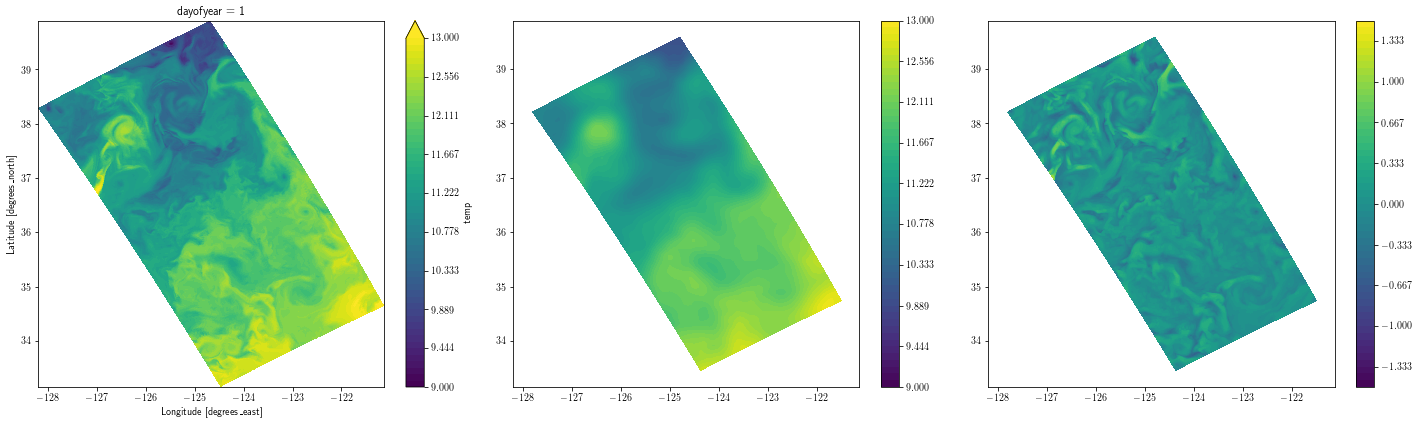

In [18]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
tf.plot(x='nav_lon_rho',y='nav_lat_rho',levels=np.linspace(9,13,55))
plt.subplot(1,3,2)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,tf_sm[:,:],levels=np.linspace(9,13,55))
plt.colorbar()
plt.subplot(1,3,3)
plt.contourf(tf.nav_lon_rho,tf.nav_lat_rho,(tf-tf_sm[:,:]),levels=np.linspace(-1.5,1.5,55))
plt.colorbar()
plt.tight_layout()

In [25]:
xlim=50
tfM=xr.DataArray(tf_sm)

sptf=xrft.isotropic_power_spectrum(tf.drop(['nav_lon_rho','nav_lat_rho']),
                                           nfactor=2,dimtruncate='True',detrend='linear', window=True)
Sm_sptf=xrft.isotropic_power_spectrum(tfM.drop(['nav_lon_rho','nav_lat_rho'])[xlim:-xlim,xlim:-xlim],
                                      nfactor=2,dimtruncate='True',detrend='linear', window=True)
Fil_sptf=xrft.isotropic_power_spectrum((tf-tf_sm).drop(['nav_lon_rho','nav_lat_rho'])[xlim:-xlim,xlim:-xlim],
                                           nfactor=2,dimtruncate='True',detrend='linear', window=True)

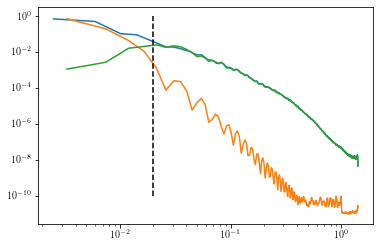

In [26]:
plt.figure()
plt.plot(sptf.freq_r/0.5,sptf)
plt.plot(Sm_sptf.freq_r/0.5,Sm_sptf)
plt.plot(Fil_sptf.freq_r/0.5,Fil_sptf)


plt.plot([1/(50),1/(50)],[1e-10,1],'k--')
plt.xscale('log')
plt.yscale('log')